In [65]:
# !pip install seaborn


In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats

In [67]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)
print('Number of subjects who completed the second session: ', len(files_secondSess))

Number of total sessions:  360
Number of subjects who completed the second session:  171


In [68]:
# print('------first session------')
# for f in files_firstSess:
#     print(f)
    
# print('------second session------')
# for f in files_secondSess:
#     print(f)


# Data cleaning

## Check if all experiments are completed

In [69]:
def checkIfComplete(mydir, files):
    
    numSess = len(files)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        # print(files[sess])
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
            print(f'Warning: incomplete experiment (session: {sess})')
            
    print(f'Completion check completed! ({numSess} files total)')
                        

In [70]:
checkIfComplete(dir_firstSess, files_firstSess)

Completion check completed! (189 files total)


In [71]:
checkIfComplete(dir_secondSess, files_secondSess)

Completion check completed! (171 files total)


## Acquire thresholds for all tasks

### Functions:

In [72]:
def getThresholds(mydir, files, condition_names, num_trials_per_staircase=35,
                     exclude_trial_count_bool=True, exclude_questSD=True, linear_scale_bool = True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_thresholds = {}
        
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_thresholds['prolificID'] = prolificID

        for cat in range(numThresholdsCat):
            
            condition_threshold = 0
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            condition_logThreshold = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
 
            if linear_scale_bool:
                # Convert to linear scale 
                condition_threshold = 10 ** condition_logThreshold
            else:
                condition_threshold = condition_logThreshold
            

            if exclude_trial_count_bool: 
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())
                if not trial_sent_bool:
                    condition_threshold = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    condition_threshold = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
                    
            assert condition_threshold != 0, 'Error: threshold not assigned'
            subj_thresholds[condition_name] = condition_threshold
        
        all_data.append(subj_thresholds)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


In [73]:
def getRSVPThresholds_wpm(mydir, files, condition_names, num_trials_per_staircase=24,
                     exclude_trial_count_bool=True, exclude_questSD=True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
     
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            # Extract threshold: 
            # check that only 1 threshold is reported for this condition
            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
            subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)

            if exclude_trial_count_bool: 
                        
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())

                if not trial_sent_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                
                if not small_questSD_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
            
        
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
        

In [74]:
def getOrdReadingSpeed(mydir, files, condition_dict,
                       accuracy_criterion_percent=60, wpm_criterion=400):
    '''
    accuracy_criterion_percent: the reading speed will be marked as np.nan if the accuracy for the comprehension question
                                is lower than this percentage
    wpm_criteiron: the reading speed will be marked as np.nan if it is higher than this percentage
    '''
    
    condition_names = list(condition_dict.keys())
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):
        
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID         
        
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]

            # Check if the participant answered 3 or more questions correctly
            question_labels = condition_dict[condition_name]
            num_questions = len(question_labels)
            question_correct_bool = np.full(num_questions,np.nan)
            for qq in range(num_questions):

                qq_data = mainOutput[mainOutput['questionAndAnswerNickname'] == question_labels[qq]]
                
                question_correct_bool[qq] = (qq_data['questionAndAnswerCorrectAnswer'].item() == qq_data['questionAndAnswerResponse'].item())
                
            percent_correct = sum(question_correct_bool) / num_questions * 100 
            
            # calculate reading speed
            speed_data = mainOutput[mainOutput['conditionName'] == condition_name]
            numWords = speed_data['readingPageWords'].dropna()
            reading_time = speed_data['readingPageDurationOnsetToOffsetSec'].dropna()
            pg_wordsPerMin = numWords / (reading_time / 60)
            include_wordsPerMin = pg_wordsPerMin[1:len(pg_wordsPerMin)-1] # exclude first and last page
            subj_wpm[condition_name] = np.mean(include_wordsPerMin)
            
            if percent_correct < accuracy_criterion_percent: 
                # print(f'Warning: percent correct is too low: session {sess}, passage {cat}')
                subj_wpm[condition_name] = np.nan

            if np.mean(include_wordsPerMin) > wpm_criterion:
                # print(f'Warning: ordinary reading speed is too high: session {sess}, passage {cat}')
                # print(f'-- wpm: {np.mean(include_wordsPerMin)}')
                subj_wpm[condition_name] = np.nan

    
                
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            

### Acquire thresholds:

- letter acuity (log deg)
- crowding acuity (log deg)
- RSVP reading speed (word duration, log sec)
- ordinary reading speed (words per min)

In [75]:
# first session

thresholds_names_sess1 = ['crowding_R8_block1','crowding_L8_block1',
                          'crowding_R8_block2','crowding_L8_block2',
                          'acuity_R8_block1','acuity_L8_block1']
df_firstSess = getThresholds(dir_firstSess, files_firstSess, thresholds_names_sess1, exclude_trial_count_bool=True, exclude_questSD=True)

# thresholds_vernier_sess1 = ['vernier_R8_block1','vernier_L8_block1']
# df_firstSess_vernier = getThresholds(dir_firstSess, files_firstSess, thresholds_vernier_sess1, exclude_trial_count_bool=True, exclude_questSD=False)

thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
# df_firstSess_rsvp = _wpm(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, exclude_trial_count_bool=True, exclude_questSD=True)
df_firstSess_rsvp = getThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, 
                                  num_trials_per_staircase=24, exclude_trial_count_bool=True, exclude_questSD=True) # word duration log sec

thresholds_names_read1 = {
        'reading_Beaver_block1': ['Beaver_1','Beaver_2','Beaver_3','Beaver_4','Beaver_5'],
        'reading_Winter_block2': ['Winter_1','Winter_2','Winter_3','Winter_4','Winter_5']}
df_firstSess_reading = getOrdReadingSpeed(dir_firstSess, files_firstSess, thresholds_names_read1, accuracy_criterion_percent=60, wpm_criterion=100000)

In [76]:
# second session

thresholds_names_sess2 = ['crowding_R8_block3','crowding_L8_block3',
                          'crowding_R8_block4','crowding_L8_block4',
                          'acuity_R8_block2','acuity_L8_block2']
df_secondSess = getThresholds(dir_secondSess, files_secondSess, thresholds_names_sess2, exclude_trial_count_bool=True, exclude_questSD=True)

# thresholds_vernier_sess2 = ['vernier_R8_block2','vernier_L8_block2']
# df_secondSess_vernier = getThresholds(dir_secondSess, files_secondSess, thresholds_vernier_sess2, exclude_trial_count_bool=True, exclude_questSD=False)

thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
# df_secondSess_rsvp = getRSVPThresholds_wpm(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, exclude_trial_count_bool=True, exclude_questSD=True)
df_secondSess_rsvp = getThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, 
                                  num_trials_per_staircase=24, exclude_trial_count_bool=True, exclude_questSD=True) # word duration log sec

thresholds_names_read2 = {
        'reading_Desert_block1': ['Desert_1','Desert_2','Desert_3','Desert_4','Desert_5'],
        'reading_Islands_block2': ['Islands_1','Islands_2','Islands_3','Islands_4','Islands_5']}

df_secondSess_reading = getOrdReadingSpeed(dir_secondSess, files_secondSess, thresholds_names_read2, accuracy_criterion_percent=60, wpm_criterion=100000)

In [77]:
# merge data frames
df_first_merge = pd.merge(df_firstSess, df_firstSess_rsvp, on="prolificID", how="inner")
df_first = pd.merge(df_first_merge, df_firstSess_reading, on="prolificID", how="inner")

df_second_merge = pd.merge(df_secondSess, df_secondSess_rsvp, on="prolificID", how="inner")
df_second = pd.merge(df_second_merge, df_secondSess_reading, on="prolificID", how="inner")

df_both_sessions = pd.merge(df_first, df_second, on="prolificID", how="inner")

# Check if there are any 0 or negative values in df_both_sessions
numeric_df = df_both_sessions.select_dtypes(include=[np.number])
if ((numeric_df <= 0) & ~numeric_df.isna()).any().any():
    print("Check if you wanted to use logged thresholds.")

# display(df_both_sessions)
# print(df_both_sessions.columns)
print(df_both_sessions.head())


                 prolificID  crowding_R8_block1  crowding_L8_block1  \
0  5f0788c06b220f03231666a0            1.106513            1.510901   
1  64837ba51422d817b62cc5cc            2.559539            1.912905   
2  6778842e3f7e2e62756f7178            2.489716            3.084324   
3  5e57d38b533eec1818078f0b            3.301008            3.195551   
4  6501b789e3ddbc0a0b79b925            2.217364            3.307357   

   crowding_R8_block2  crowding_L8_block2  acuity_R8_block1  acuity_L8_block1  \
0            0.746883            1.948321          0.337192          0.332784   
1                 NaN                 NaN               NaN               NaN   
2            1.832141            2.359464          0.509917          0.365917   
3            3.253969            2.526254          0.316263          0.340914   
4            1.164032            1.236015          0.415823          0.367360   

   rsvp_foveal_block1  reading_Beaver_block1  reading_Winter_block2  \
0            0.

In [78]:
print('First session: ', len(df_first))
print('Second session: ', len(df_second))

print('Number of subjects with complete data for both sessions: ', len(df_both_sessions))


First session:  189
Second session:  171
Number of subjects with complete data for both sessions:  169


### For each task, exclude all thresholds from a participant if one threshold is abnormal

In [79]:
def nan_out_task(df, task_prefixes):
    df = df.copy()
    for prefix in task_prefixes:
        task_cols = [col for col in df.columns if col.startswith(prefix)]
        # Find rows where any of the task columns is nan
        mask = df[task_cols].isna().any(axis=1)
        # Set all task columns to nan for those rows
        df.loc[mask, task_cols] = np.nan
    return df

In [80]:
task_prefixes = ['crowding', 'acuity', 'rsvp', 'reading']

# Apply to your data frame
df_both_sessions_exclude_subj_task = nan_out_task(df_both_sessions, task_prefixes)

Note: cleaned data frames:
- df_both_sessions: all thresholds for participants who completed both sessions
- df_both_sessions_exclude_subj_task: exclude a participant for the whole task if the participant has at least 1 threshold excluded

### Average thresholds within the same block

In [81]:
df_perBlock = df_both_sessions_exclude_subj_task.copy()

def row_gmean(row):
    values = row.dropna()
    values = values[values > 0]  # keep only positive values
    return stats.gmean(values) if len(values) >= 2 else np.nan

df_perBlock['crowding_block1'] = df_perBlock[['crowding_R8_block1', 'crowding_L8_block1']].apply(row_gmean, axis=1)
df_perBlock['crowding_block2'] = df_perBlock[['crowding_R8_block2', 'crowding_L8_block2']].apply(row_gmean, axis=1)
df_perBlock['crowding_block3'] = df_perBlock[['crowding_R8_block3', 'crowding_L8_block3']].apply(row_gmean, axis=1)
df_perBlock['crowding_block4'] = df_perBlock[['crowding_R8_block4', 'crowding_L8_block4']].apply(row_gmean, axis=1)
df_perBlock['acuity_block1']   = df_perBlock[['acuity_R8_block1',   'acuity_L8_block1'  ]].apply(row_gmean, axis=1)
df_perBlock['acuity_block2']   = df_perBlock[['acuity_R8_block2',   'acuity_L8_block2'  ]].apply(row_gmean, axis=1)
df_perBlock['reading_block1']  = df_perBlock[['reading_Beaver_block1',  'reading_Desert_block1']].apply(row_gmean, axis=1)
df_perBlock['reading_block2']  = df_perBlock[['reading_Winter_block2', 'reading_Islands_block2']].apply(row_gmean, axis=1)


In [96]:
columns_to_keep = [
    'crowding_block1', 'crowding_block2', 'crowding_block3', 'crowding_block4',
    'acuity_block1', 'acuity_block2',
	'rsvp_foveal_block1', 'rsvp_foveal_block2',
    'reading_block1', 'reading_block2'
]

df_perBlock = df_perBlock[columns_to_keep].copy()

### Test-retest ratio
- log(test/retest), i.e., log(test) - log(retest), note: not the ratio of the logged thresholds; take the ratio between the numerical thresholds and then take the log.
- if test and retest are very different, then it means that the participant is unreliable and therefore should be excluded 

In [83]:
def compute_test_retest_ratio(df, block1_colname, block2_colname):
	'''
	Compute test-retest ratio: log(block2 / block1)
	'''
	ratio = np.log10(df[block2_colname] / df[block1_colname])
	return ratio

# def exclude_ratio(df, ratio_series, threshold=0.3):
# 	'''
# 	Exclude subjects with extreme test-retest ratios.
# 	threshold: if abs(ratio) > threshold, exclude
# 	'''
# 	mask = ratio_series.abs() <= threshold
# 	df_excluded = df[mask].copy()
# 	return df_excluded

In [97]:
df_perBlock['acuity_ratio'] = compute_test_retest_ratio(df_perBlock, 'acuity_block1', 'acuity_block2')
df_perBlock['rsvp_ratio'] = compute_test_retest_ratio(df_perBlock, 'rsvp_foveal_block1', 'rsvp_foveal_block2')
df_perBlock['reading_ratio'] = compute_test_retest_ratio(df_perBlock, 'reading_block1', 'reading_block2')

df_perBlock['crowding_ratio_12'] = compute_test_retest_ratio(df_perBlock, 'crowding_block1', 'crowding_block2')
df_perBlock['crowding_ratio_13'] = compute_test_retest_ratio(df_perBlock, 'crowding_block1', 'crowding_block3')
df_perBlock['crowding_ratio_14'] = compute_test_retest_ratio(df_perBlock, 'crowding_block1', 'crowding_block4')		
df_perBlock['crowding_ratio_23'] = compute_test_retest_ratio(df_perBlock, 'crowding_block2', 'crowding_block3')
df_perBlock['crowding_ratio_24'] = compute_test_retest_ratio(df_perBlock, 'crowding_block2', 'crowding_block4')
df_perBlock['crowding_ratio_34'] = compute_test_retest_ratio(df_perBlock, 'crowding_block3', 'crowding_block4')


In [93]:
def plot_ratio(data_array, title, num_bins=80, min_val=-2.5, max_val=2.5, abs_bool=False): # , num_bins=20, min_val=0.08, max_val=1.11
    '''
    Input:
    - data_array: an array of test-retest ratios
    - title: [string] title and x-axis label of the figure
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.linspace(min_val, max_val, num_bins + 1)
    if abs_bool:
        data_array = np.abs(data_array)
        title = 'Absolute ' + title
                
    plt.figure(figsize=(8, 2)) 
    plt.hist(data_array, bins=bins, color='lightyellow', edgecolor='black')# bins=bins
    plt.title(f"{title} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(title, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xlim(min_val, max_val)
    # plt.ylim(0,100)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

Sanity check: the distributions of the values of the ratios are normal centered at 0

In [87]:
# plot_ratio(df_perBlock['acuity_ratio'], 'Acuity Ratio')
# plot_ratio(df_perBlock['rsvp_ratio'], 'RSVP Ratio')
# plot_ratio(df_perBlock['reading_ratio'], 'Reading Speed Ratio')
# plot_ratio(df_perBlock['crowding_ratio_12'], 'Crowding Ratio Block1 vs Block2')
# plot_ratio(df_perBlock['crowding_ratio_13'], 'Crowding Ratio Block1 vs Block3')
# plot_ratio(df_perBlock['crowding_ratio_14'], 'Crowding Ratio Block1 vs Block4')
# plot_ratio(df_perBlock['crowding_ratio_23'], 'Crowding Ratio Block2 vs Block3')
# plot_ratio(df_perBlock['crowding_ratio_24'], 'Crowding Ratio Block2 vs Block4')
# plot_ratio(df_perBlock['crowding_ratio_34'], 'Crowding Ratio Block3 vs Block4')

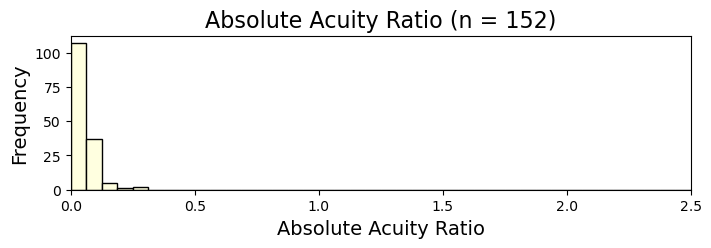

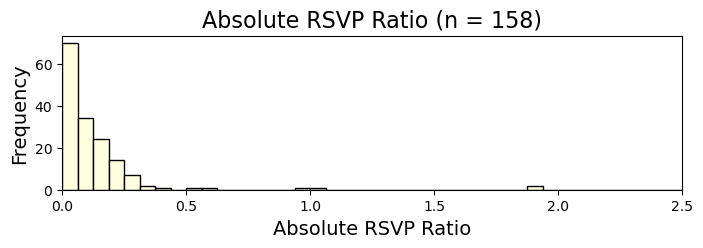

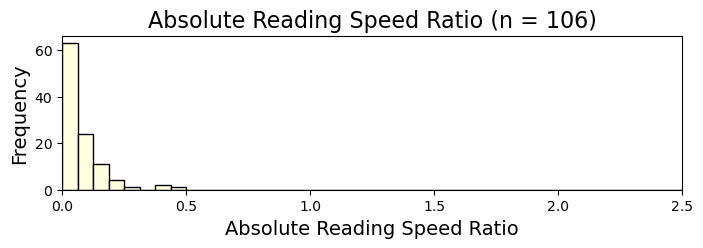

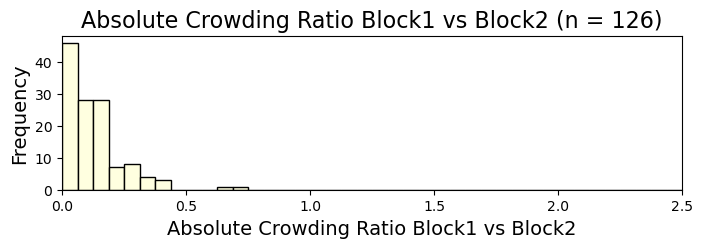

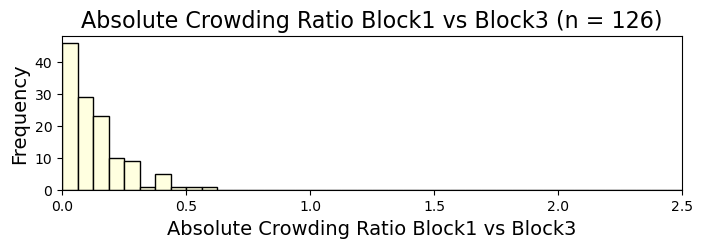

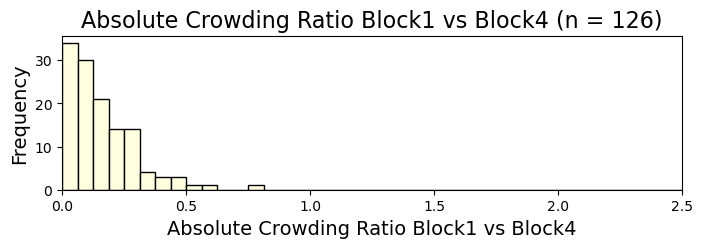

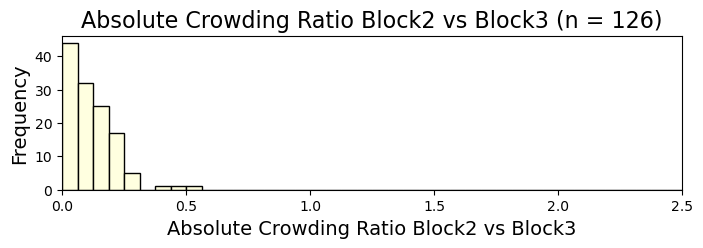

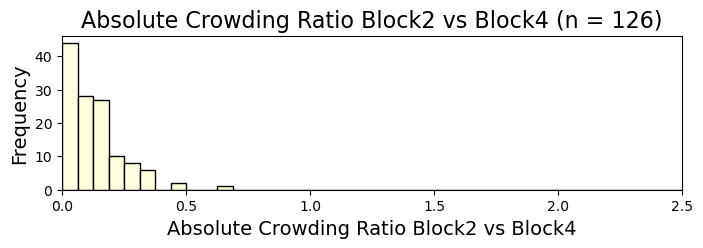

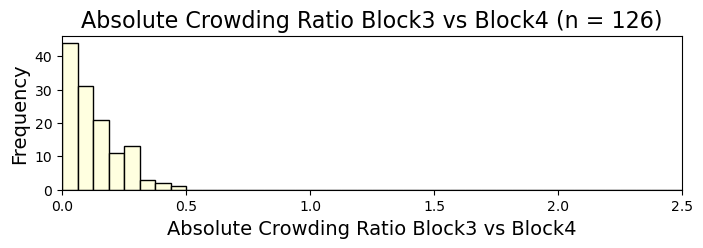

In [94]:
plot_ratio(df_perBlock['acuity_ratio'], 'Acuity Ratio', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['rsvp_ratio'], 'RSVP Ratio', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['reading_ratio'], 'Reading Speed Ratio', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['crowding_ratio_12'], 'Crowding Ratio Block1 vs Block2', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['crowding_ratio_13'], 'Crowding Ratio Block1 vs Block3', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['crowding_ratio_14'], 'Crowding Ratio Block1 vs Block4', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['crowding_ratio_23'], 'Crowding Ratio Block2 vs Block3', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['crowding_ratio_24'], 'Crowding Ratio Block2 vs Block4', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)
plot_ratio(df_perBlock['crowding_ratio_34'], 'Crowding Ratio Block3 vs Block4', abs_bool=True, num_bins=40, min_val=0, max_val=2.5)

In [98]:
print(df_perBlock.columns)

Index(['crowding_block1', 'crowding_block2', 'crowding_block3',
       'crowding_block4', 'acuity_block1', 'acuity_block2',
       'rsvp_foveal_block1', 'rsvp_foveal_block2', 'reading_block1',
       'reading_block2', 'acuity_ratio', 'rsvp_ratio', 'reading_ratio',
       'crowding_ratio_12', 'crowding_ratio_13', 'crowding_ratio_14',
       'crowding_ratio_23', 'crowding_ratio_24', 'crowding_ratio_34'],
      dtype='object')


In [ ]:
def remove_outliers_ratio(df, prefix):
	'''
	Remove subjects with extreme test-retest ratios.
	'''
	df = df.copy()
	ratio_cols = [col for col in df.columns if col.startswith(prefix) and 'ratio' in col]

	for col in ratio_cols:

		ratio_values = df[col]
		mean = ratio_values.mean(skipna=True)
		std = ratio_values.std(skipna=True)
		lower = mean - 2 * std
		upper = mean + 2 * std

		outlier_mask = (ratio_values < lower) | (ratio_values > upper)
		num_outliers = outlier_mask.sum()

		# Find the corresponding threshold column (e.g., 'crowding_block1')
		task_cols = [col for col in df.columns if col.startswith(prefix) and not 'ratio' in col]

		for task_col in task_cols:

			if task_col in df.columns:
				df.loc[outlier_mask, task_col] = np.nan
				print(f'Set {num_outliers} values in {task_col} to NaN due to outlier {col} (thresholds: {lower:.2f} to {upper:.2f})')
			else:
				print(f'Warning: {task_col} not found in DataFrame.')

	return df

In [105]:
df_cleaned = df_perBlock.copy()
df_cleaned = remove_outliers_ratio(df_cleaned, 'acuity')
df_cleaned = remove_outliers_ratio(df_cleaned, 'rsvp')
df_cleaned = remove_outliers_ratio(df_cleaned, 'reading')
df_cleaned = remove_outliers_ratio(df_cleaned, 'crowding')

acuity_block1
Set 8 values in acuity_block1 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
acuity_block2
Set 8 values in acuity_block2 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
rsvp_foveal_block1
Set 5 values in rsvp_foveal_block1 to NaN due to outlier rsvp_ratio (thresholds: -0.58 to 0.54)
rsvp_foveal_block2
Set 5 values in rsvp_foveal_block2 to NaN due to outlier rsvp_ratio (thresholds: -0.58 to 0.54)
reading_block1
Set 6 values in reading_block1 to NaN due to outlier reading_ratio (thresholds: -0.25 to 0.17)
reading_block2
Set 6 values in reading_block2 to NaN due to outlier reading_ratio (thresholds: -0.25 to 0.17)
crowding_block1
Set 6 values in crowding_block1 to NaN due to outlier crowding_ratio_12 (thresholds: -0.39 to 0.27)
crowding_block2
Set 6 values in crowding_block2 to NaN due to outlier crowding_ratio_12 (thresholds: -0.39 to 0.27)
crowding_block3
Set 6 values in crowding_block3 to NaN due to outlier crowding_ratio_12 (thresholds: -0.

## Histograms of all thresholds

### Functions

In [107]:
def extract_all_thresholds(dfs, col_name, eccentricity=8, calculate_bouma_bool=False):
    '''
    inputs:
    - dfs: an array of data frames containing thresholds
    - col_name: [string] the name of the columns we want to select
    - calculate_bouma_bool: [bool] if True, then it divides the threshold by eccentricity
    output:
    - returns an array of concatenated data
    '''
    
    data = []
    
    for df in dfs:
        all_columns = [col for col in df.columns if col.startswith(col_name)]
        all_values = df[all_columns].values.flatten()
        data.extend(all_values)
    
    data_array = np.array(data)

    if calculate_bouma_bool:
        data_array = 10 ** data_array / eccentricity
    
    return data_array

# dfs = [df_first, df_second]

In [108]:
def plot_threshold_array(data_array, threshold_name,
                         num_bins=20, min_val=0.08, max_val=1.11, plot_JOV_patch=False):
    '''
    Input:
    - data_array: an array of data (could be output from extract_all_thresholds)
    - threshold_name: [string] title and x-axis label of the figure
    - plot_JOV_patch: [bool] plots mean +- 1 sd from crowding data (Kurzawski, Burchell et al., 2023, JOV) 
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
    
    plt.figure(figsize=(8, 2)) 
    if plot_JOV_patch:
        lowerBound = 0.18
        upperBound = 0.41
        plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
    
    plt.hist(data_array, bins=bins, color='skyblue', edgecolor='black')# bins=bins
    plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(threshold_name, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xscale('log')
    # plt.xlim(0.07,1.2)
    # plt.ylim(0,125)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

### All thresholds, including subj who only completed 1 session

In [20]:
# all_letter_acuity = 10 ** extract_all_thresholds(dfs, 'acuity')
# plot_threshold_array(all_letter_acuity, 'Letter acuity',num_bins=50, min_val=0.1, max_val=25)

# all_vernier_acuity = 10 ** extract_all_thresholds(dfs, 'vernier')
# plot_threshold_array(all_vernier_acuity, 'Vernier acuity',num_bins=50, min_val=0.005, max_val=67)

# bouma = extract_all_thresholds(dfs, 'crowding', calculate_bouma_bool=True)
# plot_threshold_array(bouma, 'Bouma factors', plot_JOV_patch=True)

# all_rsvp = extract_all_thresholds(dfs, 'rsvp')
# plot_threshold_array(all_rsvp, 'RSVP threshold (wpm)',num_bins=50, min_val=6, max_val=6000)

# all_ord_wpm = extract_all_thresholds(dfs, 'reading')
# plot_threshold_array(all_ord_wpm, 'Ordinary reading speed',num_bins=200, min_val=50, max_val=12000)

### All thresholds from subj who completed both sessions

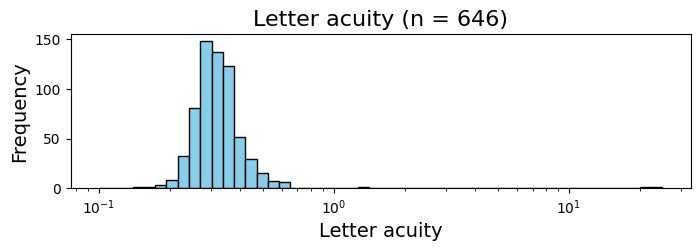

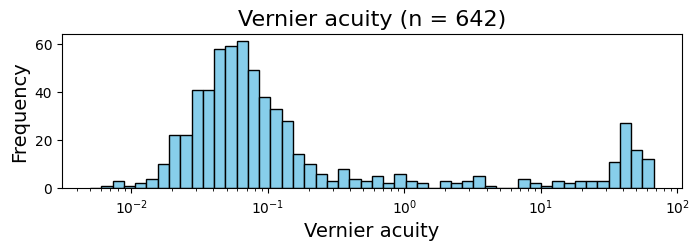

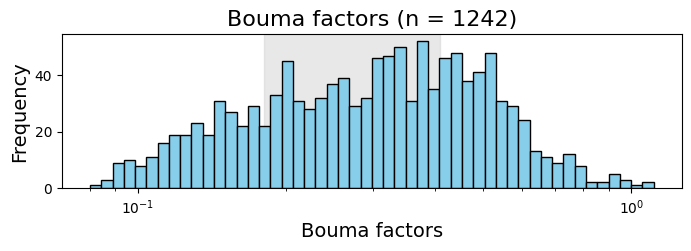

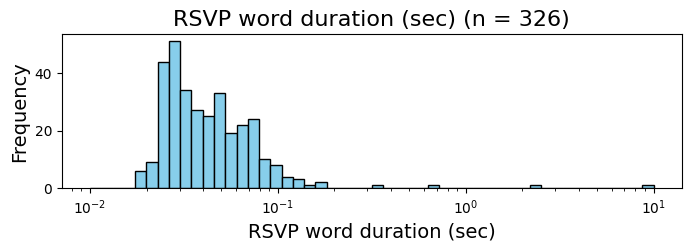

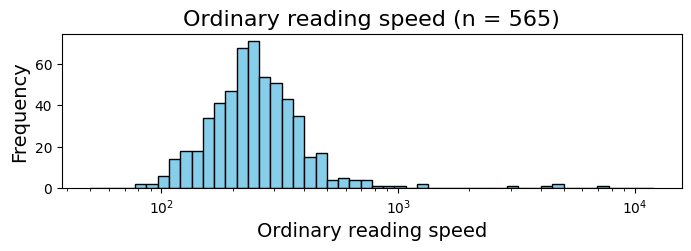

In [21]:
all_letter_acuity = 10 ** extract_all_thresholds([df_both_sessions], 'acuity')
plot_threshold_array(all_letter_acuity, 'Letter acuity',num_bins=50, min_val=0.1, max_val=25)

all_vernier_acuity = 10 ** extract_all_thresholds([df_both_sessions], 'vernier')
plot_threshold_array(all_vernier_acuity, 'Vernier acuity',num_bins=50, min_val=0.005, max_val=67)

bouma = extract_all_thresholds([df_both_sessions], 'crowding', calculate_bouma_bool=True)
plot_threshold_array(bouma, 'Bouma factors',num_bins=50, plot_JOV_patch=True)

all_rsvp = 10 ** extract_all_thresholds([df_both_sessions], 'rsvp')
plot_threshold_array(all_rsvp, 'RSVP word duration (sec)',num_bins=50, min_val=0.01, max_val=10)

all_ord_wpm = extract_all_thresholds([df_both_sessions], 'reading')
plot_threshold_array(all_ord_wpm, 'Ordinary reading speed',num_bins=50, min_val=50, max_val=12000)

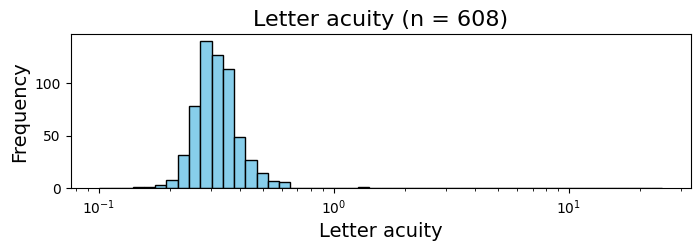

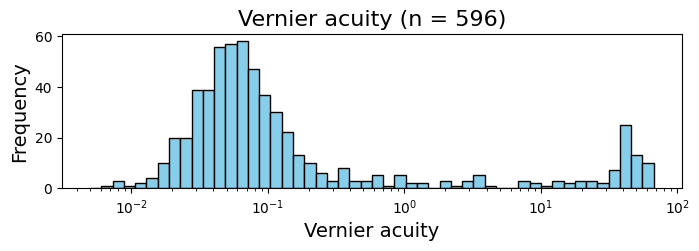

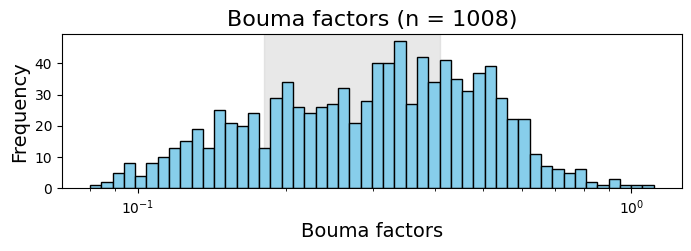

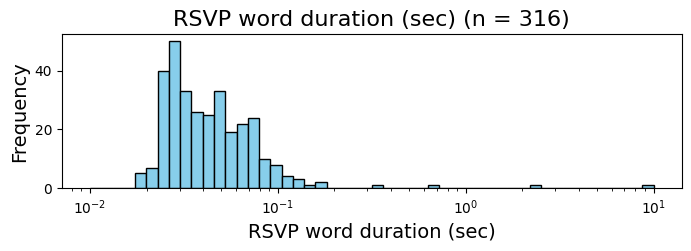

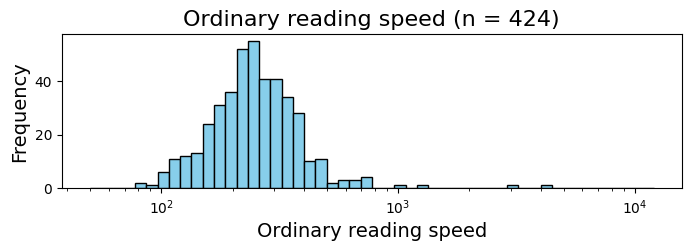

In [22]:
all_letter_acuity = 10 ** extract_all_thresholds([df_both_sessions_exclude_subj_task], 'acuity')
plot_threshold_array(all_letter_acuity, 'Letter acuity',num_bins=50, min_val=0.1, max_val=25)

all_vernier_acuity = 10 ** extract_all_thresholds([df_both_sessions_exclude_subj_task], 'vernier')
plot_threshold_array(all_vernier_acuity, 'Vernier acuity',num_bins=50, min_val=0.005, max_val=67)

bouma = extract_all_thresholds([df_both_sessions_exclude_subj_task], 'crowding', calculate_bouma_bool=True)
plot_threshold_array(bouma, 'Bouma factors', num_bins=50, plot_JOV_patch=True)

all_rsvp = 10 ** extract_all_thresholds([df_both_sessions_exclude_subj_task], 'rsvp')
plot_threshold_array(all_rsvp, 'RSVP word duration (sec)',num_bins=50, min_val=0.01, max_val=10)

all_ord_wpm = extract_all_thresholds([df_both_sessions_exclude_subj_task], 'reading')
plot_threshold_array(all_ord_wpm, 'Ordinary reading speed',num_bins=50, min_val=50, max_val=12000)

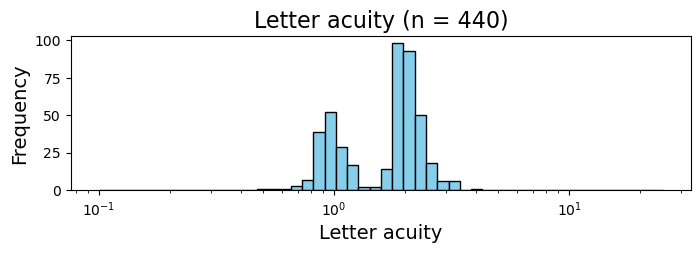

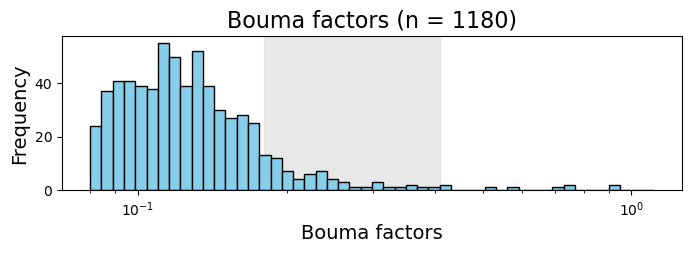

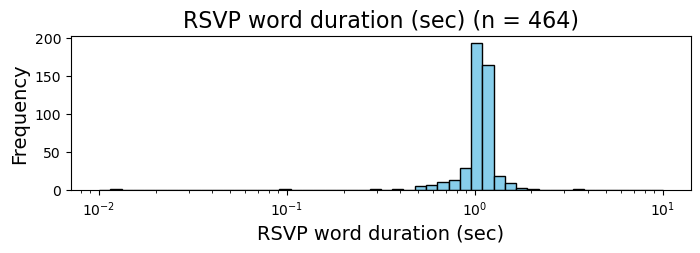

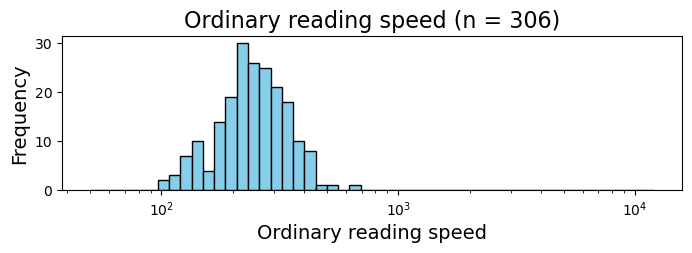

In [110]:
all_letter_acuity = 10 ** extract_all_thresholds([df_cleaned], 'acuity')
plot_threshold_array(all_letter_acuity, 'Letter acuity',num_bins=50, min_val=0.1, max_val=25)

bouma = extract_all_thresholds([df_cleaned], 'crowding', calculate_bouma_bool=True)
plot_threshold_array(bouma, 'Bouma factors', num_bins=50, plot_JOV_patch=True)

all_rsvp = 10 ** extract_all_thresholds([df_cleaned], 'rsvp')
plot_threshold_array(all_rsvp, 'RSVP word duration (sec)',num_bins=50, min_val=0.01, max_val=10)

all_ord_wpm = extract_all_thresholds([df_cleaned], 'reading')
plot_threshold_array(all_ord_wpm, 'Ordinary reading speed',num_bins=50, min_val=50, max_val=12000)

# Analysis
For df_both_sessions and df_both_sessions_exclude_subj_task:
- letter, vernier, crowding are in logged deg: when we take the mean directly, it's taking the geometric mean
- rsvp and ordinary reading speeds are in words per minute: remember to log before taking the mean! 

In [ ]:
df_for_analysis = df_both_sessions_exclude_subj_task.copy()

## Function

In [ ]:
def plot_scatter_with_correlation(df, var_x, var_y, title, 
                                  plotXequalsY_bool=False, equal_axes_bool=True):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    df = df.copy()
    
	# print out minimum and maximum values of the variables
    min_x = df[var_x].min()
    min_y = df[var_y].min()
    max_x = df[var_x].max()
    max_y = df[var_y].max()
    print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')
    
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # Determine axis limits (same for both axes)
    min_val = min(df[var_x].min(), df[var_y].min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(df[var_x].max(), df[var_y].max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=df[var_x], y=df[var_y], s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    if equal_axes_bool:
        plt.axis('equal')
        plt.gca().set_aspect('equal', adjustable='box')
        # plt.xlim(min_val, max_val)
        # plt.ylim(min_val, max_val)
    else:
        plt.gca().set_aspect('auto', adjustable='box')  


    # Add title with Pearson's r value
    plt.title(title + f"\n r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x, fontsize=14)
    plt.ylabel(var_y, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Show plot
    plt.show()


## Test-retest

In [24]:
df_for_analysis['crowding_R8_12'] = (df_for_analysis['crowding_R8_block1'] + 
                                      df_for_analysis['crowding_R8_block2']) / 2

df_for_analysis['crowding_L8_12'] = (df_for_analysis['crowding_L8_block1'] + 
                                      df_for_analysis['crowding_L8_block2']) / 2

df_for_analysis['crowding_R8_34'] = (df_for_analysis['crowding_R8_block3'] + 
                                      df_for_analysis['crowding_R8_block4']) / 2

df_for_analysis['crowding_L8_34'] = (df_for_analysis['crowding_L8_block3'] + 
                                      df_for_analysis['crowding_L8_block4']) / 2

df_for_analysis['crowding_RL_12'] = (df_for_analysis['crowding_R8_block1'] + 
                                      df_for_analysis['crowding_R8_block2'] +
                                      df_for_analysis['crowding_L8_block1'] +
									  df_for_analysis['crowding_L8_block2'])/ 4

df_for_analysis['crowding_RL_34'] = (df_for_analysis['crowding_R8_block3'] + 
                                      df_for_analysis['crowding_R8_block4'] +
                                      df_for_analysis['crowding_L8_block3'] +
									  df_for_analysis['crowding_L8_block4'])/ 4

In [25]:
df_for_analysis['ordreading_sess1'] = 10 ** ((np.log10(df_for_analysis['reading_Beaver_block1']) + 
                                               np.log10(df_for_analysis['reading_Winter_block2'])) / 2)

df_for_analysis['ordreading_sess2'] = 10 ** ((np.log10(df_for_analysis['reading_Desert_block1']) + 
                                               np.log10(df_for_analysis['reading_Islands_block2'])) / 2)

Min and max values: min_x: -0.23002857100000002, max_x: 0.86417281925, min_y: -0.4204831905, max_y: 0.9955569615000001


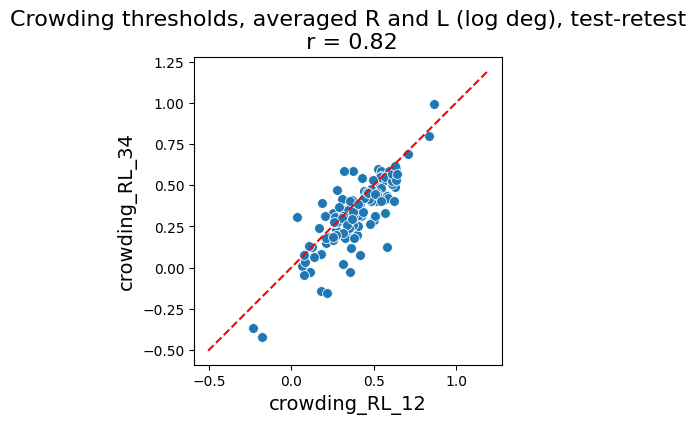

In [27]:
plot_scatter_with_correlation(df_for_analysis, "crowding_RL_12", "crowding_RL_34", 
                              'Crowding thresholds, averaged R and L (log deg), test-retest', plotXequalsY_bool=True)

Min and max values: min_x: -0.32017879800000004, max_x: 0.8229247040000001, min_y: -0.3589256775, max_y: 0.7778275635


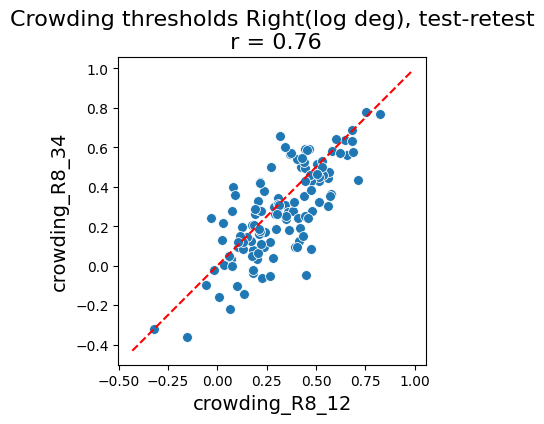

In [28]:
plot_scatter_with_correlation(df_for_analysis, "crowding_R8_12", "crowding_R8_34", 
                              'Crowding thresholds Right(log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: -0.1996519425, max_x: 0.976682131, min_y: -0.4820407035, max_y: 1.2132863595


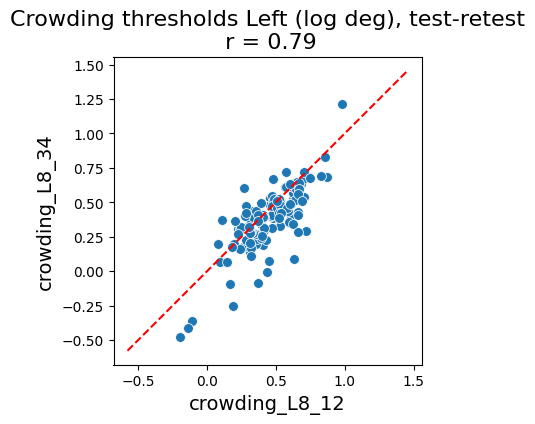

In [29]:
plot_scatter_with_correlation(df_for_analysis, "crowding_L8_12", "crowding_L8_34", 
                              'Crowding thresholds Left (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: -0.341947451, max_x: 0.71993373, min_y: -0.316721427, max_y: 0.95195783


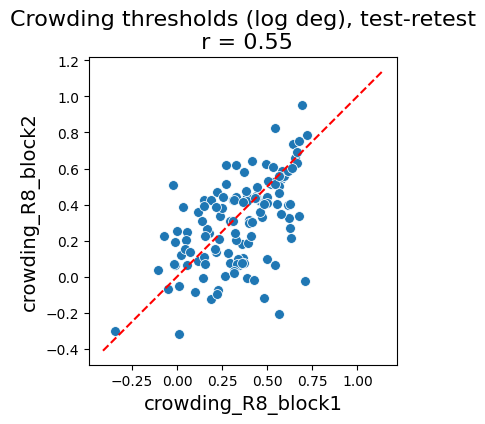

In [30]:
plot_scatter_with_correlation(df_for_analysis, "crowding_R8_block1", "crowding_R8_block2", 
                              'Crowding thresholds (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: -0.375580606, max_x: 0.813134941, min_y: -0.371533276, max_y: 0.917019364


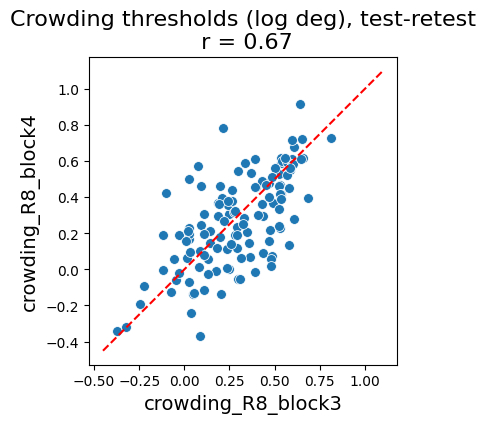

In [31]:
plot_scatter_with_correlation(df_for_analysis, "crowding_R8_block3", "crowding_R8_block4", 
                              'Crowding thresholds (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: -0.67109819, max_x: -0.214250031, min_y: -0.723921576, max_y: -0.227707751


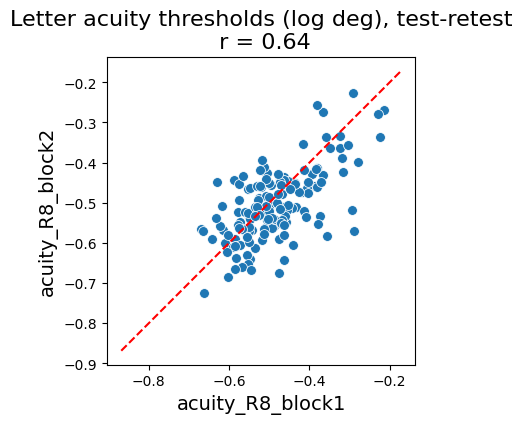

In [32]:
plot_scatter_with_correlation(df_for_analysis, "acuity_R8_block1", "acuity_R8_block2", 
                              'Letter acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: -1.864009291, max_x: 1.844910499, min_y: -2.115501483, max_y: 1.799385763


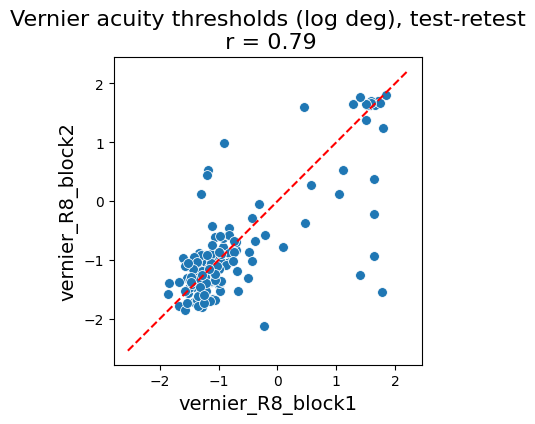

In [33]:
plot_scatter_with_correlation(df_for_analysis, "vernier_R8_block1", "vernier_R8_block2", 
                              'Vernier acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: -1.705496565, max_x: 0.381703055, min_y: -1.705496565, max_y: 0.952706987


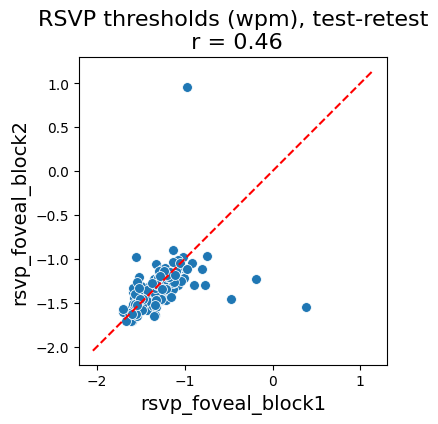

In [34]:
plot_scatter_with_correlation(df_for_analysis, "rsvp_foveal_block1", "rsvp_foveal_block2", 
                              'RSVP thresholds (wpm), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: 108.89447437550407, max_x: 1653.7957511732634, min_y: 105.46964181855063, max_y: 1470.711372043106


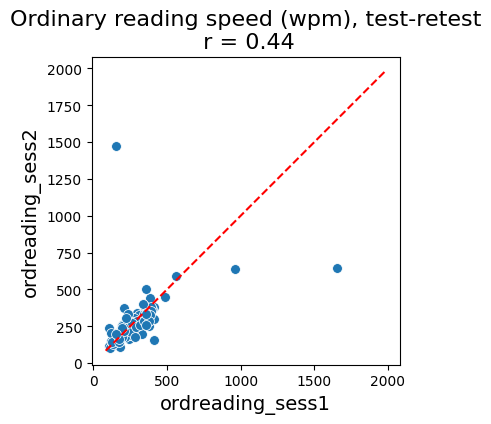

In [35]:
plot_scatter_with_correlation(df_for_analysis, "ordreading_sess1", "ordreading_sess2", 
                              'Ordinary reading speed (wpm), test-retest', plotXequalsY_bool=True)

## Average over repeats for each participant

In [36]:
# average between sessions

subj_avg_thresholds = {}


subj_avg_thresholds['crowding_R8'] = (df_for_analysis['crowding_R8_12'] + 
                                      df_for_analysis['crowding_R8_34']) / 2
subj_avg_thresholds['crowding_L8'] = (df_for_analysis['crowding_L8_12'] + 
                                      df_for_analysis['crowding_L8_34']) / 2
subj_avg_thresholds['crowding_RL'] = (subj_avg_thresholds['crowding_R8'] + 
                                      subj_avg_thresholds['crowding_L8']) / 2

subj_avg_thresholds['acuity_R8'] = (df_for_analysis['acuity_R8_block1'] + 
                                      df_for_analysis['acuity_R8_block2']) / 2
subj_avg_thresholds['acuity_L8'] = (df_for_analysis['acuity_L8_block1'] + 
                                      df_for_analysis['acuity_L8_block2']) / 2
subj_avg_thresholds['acuity_RL'] = (subj_avg_thresholds['acuity_R8'] + 
                                      subj_avg_thresholds['acuity_L8']) / 2

subj_avg_thresholds['vernier_R8'] = (df_for_analysis['vernier_R8_block1'] + 
                                      df_for_analysis['vernier_R8_block2']) / 2
subj_avg_thresholds['vernier_L8'] = (df_for_analysis['vernier_L8_block1'] + 
                                      df_for_analysis['vernier_L8_block2']) / 2
subj_avg_thresholds['vernier_RL'] = (subj_avg_thresholds['vernier_R8'] + 
                                      subj_avg_thresholds['vernier_L8']) / 2

# subj_avg_thresholds['rsvp_log'] =  ((np.log10(df_for_analysis['rsvp_foveal_block1']) + 
#                                       np.log10(df_for_analysis['rsvp_foveal_block2'])) / 2)
subj_avg_thresholds['rsvp_log'] =  (((df_for_analysis['rsvp_foveal_block1']) + 
                                      (df_for_analysis['rsvp_foveal_block2'])) / 2)

subj_avg_thresholds['ordinary_reading_log'] = ((np.log10(df_for_analysis['ordreading_sess1']) + 
                                               np.log10(df_for_analysis['ordreading_sess2'])) / 2)

df_subj_avg = pd.DataFrame(subj_avg_thresholds)
df_subj_avg.head()

,crowding_R8,crowding_L8,crowding_RL,acuity_R8,acuity_L8,acuity_RL,vernier_R8,vernier_L8,vernier_RL,rsvp_log,ordinary_reading_log
0,NaN,NaN,NaN,-0.455488,-0.480413,-0.467951,NaN,NaN,NaN,-1.510100,2.670057
1,NaN,NaN,NaN,NaN,NaN,NaN,-0.854023,-0.712736,-0.783379,-1.597345,2.355056
2,NaN,NaN,NaN,-0.260104,-0.470835,-0.365470,-0.848276,-1.371608,-1.109942,-1.654094,2.371740
3,0.471304,0.490619,0.480962,-0.497051,-0.501366,-0.499208,-0.759849,-0.819291,-0.789570,-1.196941,NaN
4,0.267549,0.321439,0.294494,-0.397104,-0.474764,-0.435934,1.463172,1.613224,1.538198,-1.544284,2.447886


## Is there left-right asymmetry?

Min and max values: min_x: -0.32081986575000004, max_x: 0.7962512472500001, min_y: -0.340846323, max_y: 1.09498424525


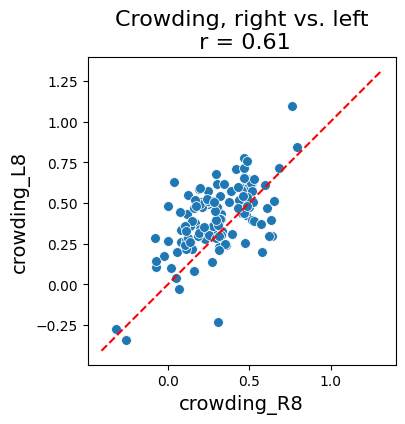

In [37]:
plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
                              'Crowding, right vs. left', plotXequalsY_bool=True)

Min and max values: min_x: -0.6930698685, max_x: -0.2418104055, min_y: -0.818130042, max_y: -0.11760238850000002


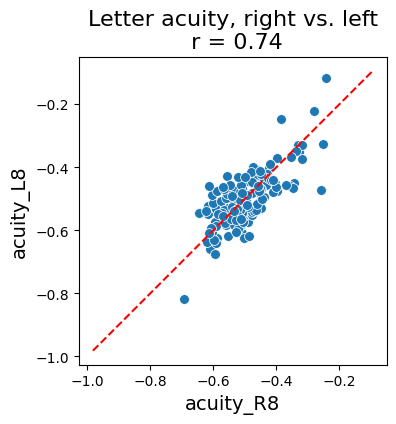

In [38]:
plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
                              'Letter acuity, right vs. left', plotXequalsY_bool=True)

Min and max values: min_x: -1.7193778155, max_x: 1.822148131, min_y: -1.9145690265000002, max_y: 1.8345828014999999


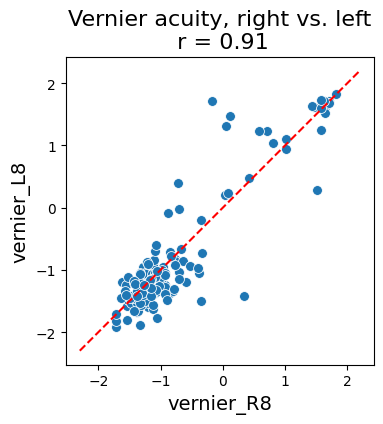

In [39]:
plot_scatter_with_correlation(df_subj_avg, "vernier_R8", "vernier_L8", 
                              'Vernier acuity, right vs. left', plotXequalsY_bool=True)

## Correlation between tasks

### Scatter plots with measured R

Min and max values: min_x: -0.29858858325000004, max_x: 0.929864890375, min_y: -1.689199245, max_y: -0.00856048199999998


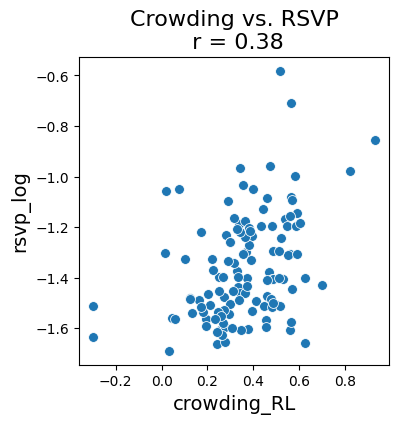

In [40]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "rsvp_log", 
                              'Crowding vs. RSVP', equal_axes_bool=False)

Min and max values: min_x: -0.29858858325000004, max_x: 0.929864890375, min_y: 2.0391113692830287, max_y: 3.0135418752821628


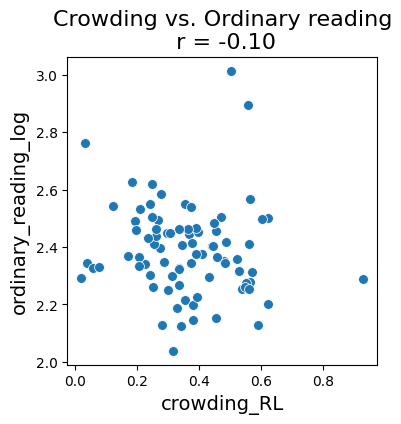

In [41]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "ordinary_reading_log", 
                              'Crowding vs. Ordinary reading', equal_axes_bool=False)

Min and max values: min_x: -0.29858858325000004, max_x: 0.929864890375, min_y: -0.7555999552499999, max_y: -0.17970639700000002


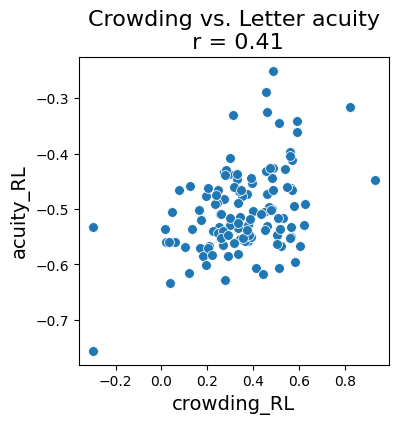

In [42]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "acuity_RL", 
                              'Crowding vs. Letter acuity', equal_axes_bool=False)

Min and max values: min_x: -0.29858858325000004, max_x: 0.929864890375, min_y: -1.8162183842500002, max_y: 1.82836546625


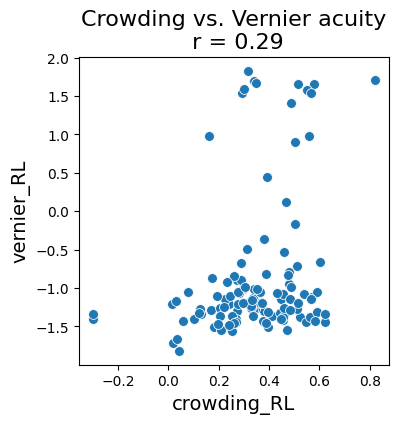

In [43]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "vernier_RL", 
                              'Crowding vs. Vernier acuity', equal_axes_bool=False)

Min and max values: min_x: -0.7555999552499999, max_x: -0.17970639700000002, min_y: -1.8162183842500002, max_y: 1.82836546625


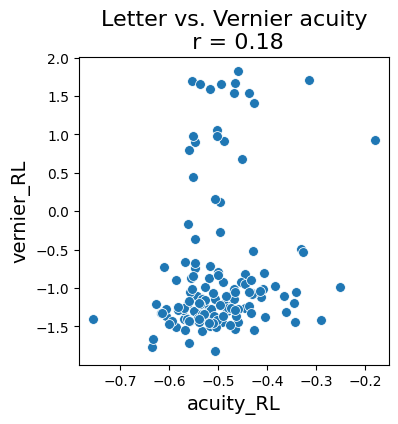

In [44]:
plot_scatter_with_correlation(df_subj_avg, "acuity_RL", "vernier_RL", 
                              'Letter vs. Vernier acuity', equal_axes_bool=False)

### Data frame with measured and corrected R

In [64]:
def print_measured_corrected_r(df, var_x, var_y, noise_ceiling_x, noise_ceiling_y):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    df = df.copy()
    
    
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r_measured, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # correction
    noise_ceiling = np.sqrt(noise_ceiling_x * noise_ceiling_y)
    r_corrected = r_measured / noise_ceiling

    print(f"Correlating: {var_x} and {var_y}: Pearson's r (measured): {r_measured:.2f}, r (corrected): {r_corrected:.2f}")
    print(f"Noise ceilings: {var_x}: {noise_ceiling_x:.2f}; {var_y}: {noise_ceiling_y:.2f}; combined: {noise_ceiling:.2f}")

    df_corr_results = pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'noise_ceiling_x': [noise_ceiling_x],
        'noise_ceiling_y': [noise_ceiling_y],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })

    return df_corr_results

    



In [55]:
print(df_subj_avg.columns)

Index(['crowding_R8', 'crowding_L8', 'crowding_RL', 'acuity_R8', 'acuity_L8',
       'acuity_RL', 'vernier_R8', 'vernier_L8', 'vernier_RL', 'rsvp_log',
       'ordinary_reading_log'],
      dtype='object')


In [48]:
filepath = 'variance_df.csv'
variance_df = pd.read_csv(filepath)
display(variance_df)

,task,within_subj_variance,btw_subj_variance,mean,r_ceiling
0,crowding,0.015011,0.033836,0.360141,0.899894
1,vernier,0.114137,0.871843,-0.803649,0.937055
2,acuity,0.002199,0.006140,-0.498284,0.835851
3,rsvp,0.039683,0.052974,3.137581,0.625804
4,reading,0.010814,0.025538,2.393177,0.787937
5,V1,0.000556,0.007229,3.448854,0.962393
6,V2,0.000505,0.004018,3.432388,0.940514
7,V3,0.001997,0.005033,3.315249,0.846299
8,V4,0.004003,0.010480,2.947784,0.836813
9,crowding_Ecc5_RL,0.004324,0.017300,0.008261,0.914395


In [68]:
df_corr_results1 = print_measured_corrected_r(df_subj_avg, 'crowding_RL', 'rsvp_log', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'rsvp']['r_ceiling'].values[0])
df_corr_results2 = print_measured_corrected_r(df_subj_avg, 'crowding_RL', 'ordinary_reading_log', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'reading']['r_ceiling'].values[0])
df_corr_results3 = print_measured_corrected_r(df_subj_avg, 'crowding_RL', 'acuity_RL', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0])
df_corr_results4 = print_measured_corrected_r(df_subj_avg, 'acuity_RL', 'rsvp_log', 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'rsvp']['r_ceiling'].values[0])
df_corr_results5 = print_measured_corrected_r(df_subj_avg, 'acuity_RL', 'ordinary_reading_log', 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'reading']['r_ceiling'].values[0])

Correlating: crowding_RL and rsvp_log: Pearson's r (measured): 0.38, r (corrected): 0.51
Noise ceilings: crowding_RL: 0.90; rsvp_log: 0.63; combined: 0.75
Correlating: crowding_RL and ordinary_reading_log: Pearson's r (measured): -0.10, r (corrected): -0.12
Noise ceilings: crowding_RL: 0.90; ordinary_reading_log: 0.79; combined: 0.84
Correlating: crowding_RL and acuity_RL: Pearson's r (measured): 0.41, r (corrected): 0.48
Noise ceilings: crowding_RL: 0.90; acuity_RL: 0.84; combined: 0.87
Correlating: acuity_RL and rsvp_log: Pearson's r (measured): 0.17, r (corrected): 0.24
Noise ceilings: acuity_RL: 0.84; rsvp_log: 0.63; combined: 0.72
Correlating: acuity_RL and ordinary_reading_log: Pearson's r (measured): -0.27, r (corrected): -0.33
Noise ceilings: acuity_RL: 0.84; ordinary_reading_log: 0.79; combined: 0.81


In [70]:
df_corr_results = pd.concat([df_corr_results1, df_corr_results2, df_corr_results3, df_corr_results4, df_corr_results5], ignore_index=True)
display(df_corr_results)

,var_x,var_y,noise_ceiling_x,noise_ceiling_y,r_measured,r_corrected
0,crowding_RL,rsvp_log,0.899894,0.625804,0.380684,0.507282
1,crowding_RL,ordinary_reading_log,0.899894,0.787937,-0.103909,-0.123399
2,crowding_RL,acuity_RL,0.899894,0.835851,0.412244,0.475328
3,acuity_RL,rsvp_log,0.835851,0.625804,0.174055,0.240660
4,acuity_RL,ordinary_reading_log,0.835851,0.787937,-0.269343,-0.331892
